In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
scv.set_figure_params('scvelo')  # for beautified visualization
%load_ext autoreload
%autoreload 2

Using device cpu


# 05c Single Cell Dataset Benchmarker
> Run FRED on a specified single cell dataset

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05c Single Cell Dataset Benchmarker"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 5
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 20
diffdist_weight = 1
num_neighbors = 10

In [ ]:
# Parameters
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "dentategyrus"
sigma = "automatic"
flow_strength = 10
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 10
diffdist_weight = 1
num_neighbors = 10
output_label = "run2_dataset_name-dentategyrus_sigma-automatic_flow_strength-10_smoothness_weight-0_flow_neighbor_loss_weight-1_contrastive_flow_loss_weight-10_diffdist_weight-1_num_neighbors-10"


# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
elif dataset_name == "dentategyrus":
    adata = scv.datasets.dentategyrus()
elif dataset_name == "pancreas":
    adata = scv.datasets.pancreas()
elif dataset_name == "dentategyrus_lamanno":
    adata = scv.datasets.dentategyrus_lamanno()

print("processing data with pcs")
X, flow, labels, n_pcs = rnavelo_pcs(adata)
# dynamical recovery
scv.tl.recover_dynamics(adata, n_jobs=6)
scv.tl.latent_time(adata)
latent_time = adata.obs['latent_time'].to_numpy()

processing data with pcs
Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
recovering dynamics (using 6/10 cores)


  0%|          | 0/1563 [00:00<?, ?gene/s]

    finished (0:01:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 2 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing latent time using root_cells as prior


    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


Set sigma =  4.1423244


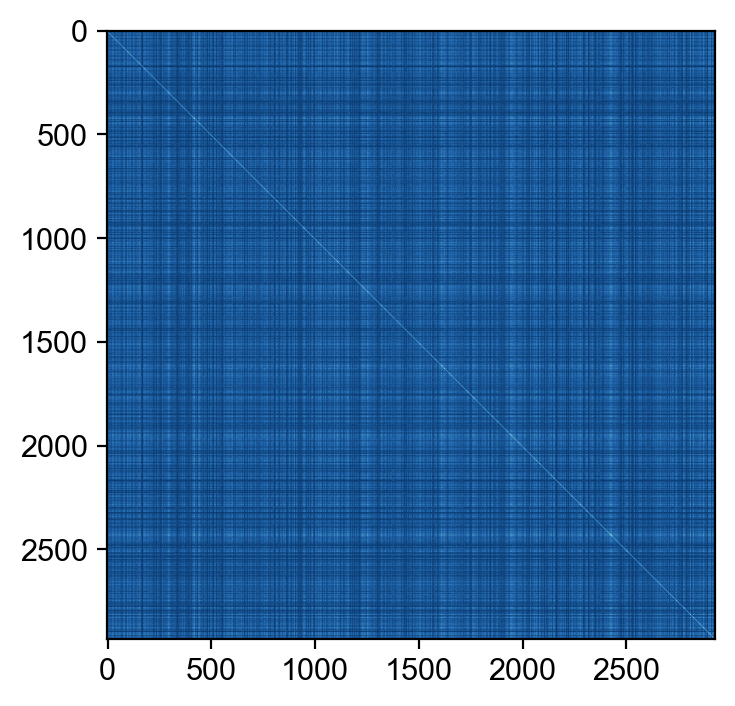

In [ ]:
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=10, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
X.shape

torch.Size([2930, 30])

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=10)

  0%|                                                                                             | 0/10 [00:00<?, ?it/s]

 10%|████████▌                                                                            | 1/10 [00:06<00:56,  6.24s/it]

 20%|█████████████████                                                                    | 2/10 [00:12<00:49,  6.22s/it]

 30%|█████████████████████████▌                                                           | 3/10 [00:18<00:43,  6.21s/it]

 40%|██████████████████████████████████                                                   | 4/10 [00:24<00:37,  6.22s/it]

 50%|██████████████████████████████████████████▌                                          | 5/10 [00:31<00:31,  6.22s/it]

 60%|███████████████████████████████████████████████████                                  | 6/10 [00:39<00:27,  6.95s/it]

 70%|███████████████████████████████████████████████████████████▍                         | 7/10 [00:46<00:20,  6.82s/it]

 80%|████████████████████████████████████████████████████████████████████                 | 8/10 [00:52<00:13,  6.63s/it]

 90%|████████████████████████████████████████████████████████████████████████████▌        | 9/10 [00:58<00:06,  6.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.47s/it]

# Results

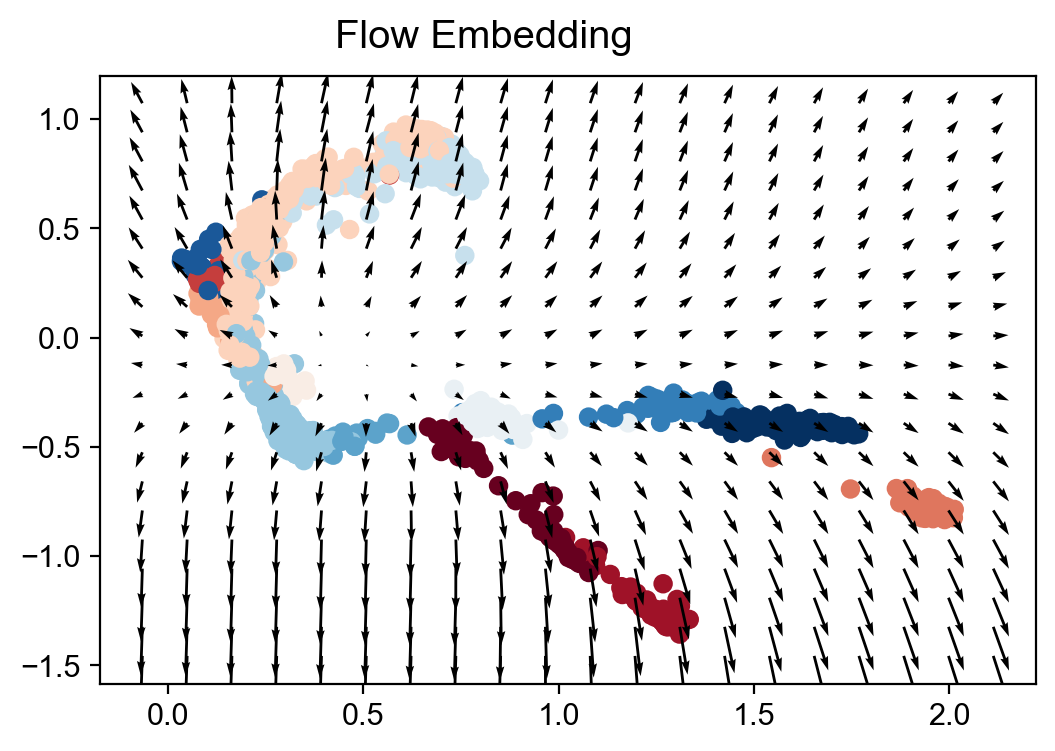

In [ ]:
FREDtrainer.visualize_embedding()

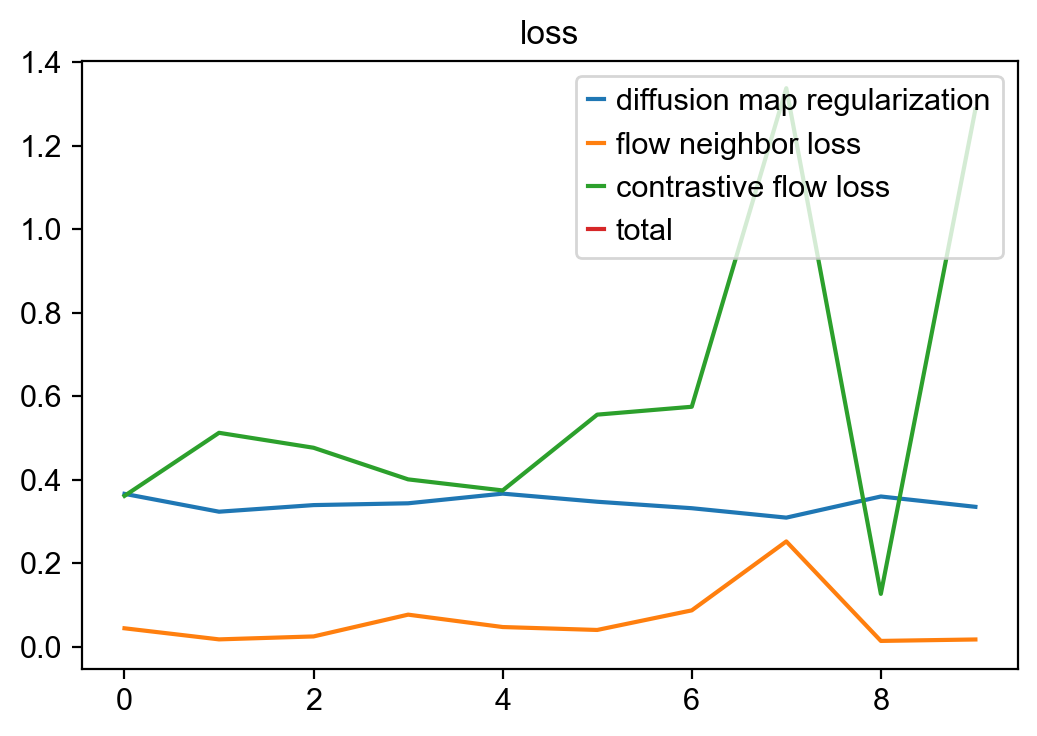

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhhANYAocAAP///////f//+///+v//9P7///z///v///3//f3/+fr///n///…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook + "_dataset_" + dataset_name
unid

'Y0im3CnqCoY4ZMbEN3Jo'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
)

Set sigma =  4.1423244


  0%|          | 0/1000 [00:00<?, ?it/s]

## SCORES ## 
 silhouette score w/o flows: 0.2188788801431656.
 silhouette score w/ flows:  0.21888142824172974 
 kNN Classifier 0.8748707342295761 
 Flow Neighbor Score 88.0087890625 
 Monotone Increasing Score -662.7401994593671


In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach())